<a href="https://colab.research.google.com/github/KangTuna/Machine-learning-and-deep-learning-practices/blob/main/RNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
# 디바이스 할당
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('drive/MyDrive/Colab Notebooks/RNN/train.csv')

In [ ]:
data

In [ ]:
features = ['Open','High','Low']
train_x = data.loc[:,features]
train_label = data['Close']
window_size = 30

In [ ]:
def make_dataset(x_data,label,window_size):
  x_list = []
  label_list = []
  for i in range(len(x_data) - window_size):
    x_list.append(np.array(x_data.iloc[i:i+window_size]))
    label_list.append(np.array(label.iloc[i+window_size]))
  x_list = torch.Tensor(np.array(x_list))
  label_list = torch.Tensor(np.array(label_list)).view(-1)
  return x_list,label_list

In [ ]:
x_data,label_data = make_dataset(train_x,train_label,window_size)

In [ ]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(x_data,label_data)
train_loader = DataLoader(train_dataset,batch_size = 32)

In [ ]:
len(train_loader)

30

In [ ]:
for data,label in train_loader:
  break
print(data.shape)
print(label.shape)

torch.Size([32, 30, 3])
torch.Size([32])


In [ ]:
class RNN(nn.Module):
  def __init__(self):
    super(RNN, self).__init__()

    self.rnn = nn.RNN(input_size = len(features), hidden_size = 8, num_layers = 5,
                      batch_first = True)

    self.fc1 = nn.Linear(in_features = window_size*8, out_features = 64)
    self.fc2 = nn.Linear(in_features = 64, out_features = 1)

    self.relu = nn.ReLU()

  def forward(self,x,h0):
    x, hn = self.rnn(x,h0)

    x = x.reshape(x.size(0),-1)

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    x = x.reshape(-1)

    return x


In [ ]:
# 난수 고정
torch.cuda.manual_seed(123)

model1 = RNN()
model1.to(device)
lr = 1e-4
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)

In [ ]:
loss_train_record = []

In [ ]:
num_epochs = 300
for epoch in range(num_epochs):
  for data, label in train_loader:

    inputs = data.to(device)
    labels = label.to(device)
    optimizer.zero_grad()
    h0 = torch.zeros(5, inputs.shape[0], 8).to(device)
    outputs = model1(inputs,h0)
    loss_train = nn.MSELoss()(outputs, labels)

    loss_train.backward()

    optimizer.step()
  loss_train_record.append(loss_train.item())
  if epoch % 100 == 0:
    print(f'epoch{epoch} loss:{loss_train.item()}')

epoch0 loss:78627.25
epoch100 loss:3174.377685546875
epoch200 loss:2729.109375


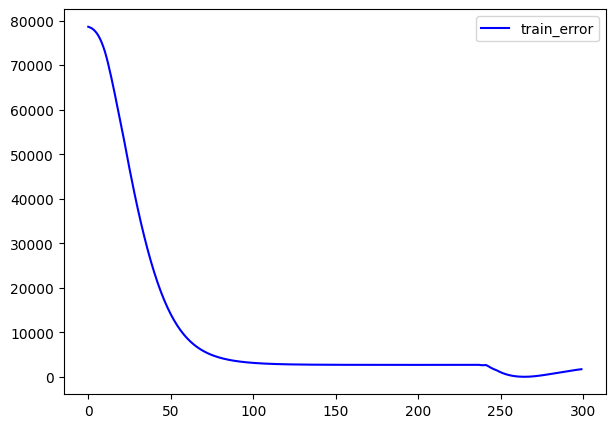

In [ ]:
plt.figure(figsize = (7,5))
plt.plot(loss_train_record,'b',label = 'train_error')
plt.legend()
plt.show()

In [ ]:
h0 = torch.zeros(5, x_data.shape[0], 8).to(device)
x_data = x_data.to(device)
preds = model1(x_data,h0)

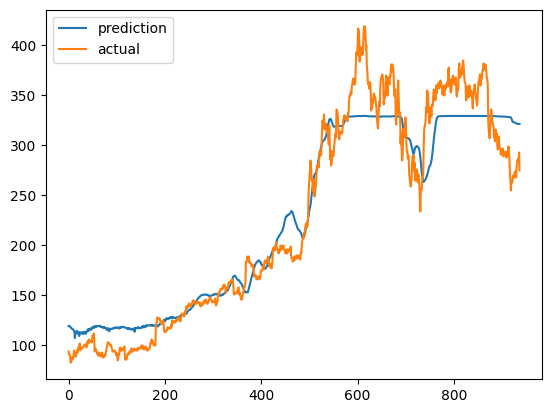

In [ ]:
plt.plot(preds.to('cpu').detach(), label = 'prediction')
plt.plot(label_data, label = 'actual')
plt.legend()
plt.show()